# **Retail Sales Analysis modules**

## Objectives

* Create a set of modules to support the analysis of the Retail Sales Data set from Kaggle to act as demonstration of skills

## Inputs

* Data will be pulled using the Kaggle API.

## Outputs

* Multiple python modules that can be loaded and resused to support re-use of analytics

## Additional Comments

* If you have any additional comments that don't fit in the previous bullets, please state them here. 



---

Hard code working directory to relative root directory of workbook.

In [2]:
import os
os.chdir('/workspace/RetailSalesRework')
print("You set a new current directory")

You set a new current directory


In [14]:
## Modules and Extensions imported
import pandas as pd
import os
import math
import numpy as np
from datetime import timedelta, date
import kagglehub
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from feature_engine.encoding import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from feature_engine.imputation import DropMissingData

# Data Acquisition

Load data using Kagglehub api - the user will need a Kaggle account and a kaggle api code.  Both of the can be obtained from [Kaggle.com](https://Kaggle.com/).  This project will be using the [Retail Data Anlaytics DataSet](https://www.kaggle.com/datasets/manjeetsingh/retaildataset)

In [6]:
## Setup Kagglehub and login
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [7]:
## load Retail Data Set using Kagglehub
kagglehub.dataset_download("manjeetsingh/retaildataset")

100%|██████████| 3.11M/3.11M [00:00<00:00, 4.96MB/s]

Extracting files...


'/home/gitpod/.cache/kagglehub/datasets/manjeetsingh/retaildataset/versions/2'

In [8]:
## List of files in folder
os.listdir('/home/gitpod/.cache/kagglehub/datasets/manjeetsingh/retaildataset/versions/2/')

['Features data set.csv', 'sales data-set.csv', 'stores data-set.csv']

In [9]:
## Load data sets
Features_df = pd.read_csv('/home/gitpod/.cache/kagglehub/datasets/manjeetsingh/retaildataset/versions/2/Features data set.csv')
Stores_df = pd.read_csv('/home/gitpod/.cache/kagglehub/datasets/manjeetsingh/retaildataset/versions/2/stores data-set.csv')
Sales_df = pd.read_csv('/home/gitpod/.cache/kagglehub/datasets/manjeetsingh/retaildataset/versions/2/sales data-set.csv')
## Merge sales_df and Stores_df on Store id - change data type of Date to Date, Store to Object and Dept to Object,
Sales_df = pd.merge(Sales_df, Stores_df, how='left', on='Store')
Sales_df['Date'] = pd.to_datetime(Sales_df['Date'], format='%d/%m/%Y')
Sales_df['Store'] = Sales_df['Store'].astype(object)
Sales_df['Dept'] = Sales_df['Dept'].astype(object)
## Clean up Features_df then create store level summary
Features_df['Date'] = pd.to_datetime(Features_df['Date'], format='%d/%m/%Y')
# Change date to date format and create year/month and week fields and YearMonth YearWeek
# Append Year column
Sales_df['SalesYear'] = round(Sales_df['Date'].dt.year)
# Append Month column 
Sales_df['SalesMonth'] = round(Sales_df['Date'].dt.month)
# append quarters column
Sales_df['SalesQuarter'] = round(Sales_df['Date'].dt.quarter)
# Append Week column
Sales_df['SalesWeek'] = round(Sales_df['Date'].dt.week)
# Create YearMonth Column
Sales_df['SalesYearMonth'] = round(Sales_df['SalesYear']*100 +Sales_df['SalesMonth'])
# Create YearWeek Column
Sales_df['SalesYearWeek'] = round(Sales_df['SalesYear']*100 +Sales_df['SalesWeek'])
# Create Season Column
SeasonsDic = {1:'Winter', 2:'Winter', 3:'Spring', 4:'Spring', 5:'Spring', 6:'Summer',7:'Summer', 8:'Summer', 9:'Autumn', 10:'Autumn', 11:'Autumn', 12:'Winter'}
Sales_df['SalesSeason'] = Sales_df['SalesMonth'].map(SeasonsDic)
SpecialSalesDic = {12:'Xmas', 3:'Easter', 4:'Easter',7:'Schoolholidays',8:'Schoolholidays',10:'Halloween'}
Sales_df['SpecialDate'] = Sales_df['SalesMonth'].map(SpecialSalesDic).fillna(Sales_df['SalesSeason'])
# Replace NaN in MarkDown as 0
Features_df['MarkDown1'] = Features_df['MarkDown1'].fillna(0)
Features_df['MarkDown2'] = Features_df['MarkDown2'].fillna(0)
Features_df['MarkDown3'] = Features_df['MarkDown3'].fillna(0)
Features_df['MarkDown4'] = Features_df['MarkDown4'].fillna(0)
Features_df['MarkDown5'] = Features_df['MarkDown5'].fillna(0)
Features_df['MarkDownTotal']= Features_df['MarkDown1']+Features_df['MarkDown2']+Features_df['MarkDown3']+Features_df['MarkDown4']+Features_df['MarkDown5']
Features_df['MarkDownData']= Features_df['MarkDownTotal']>0
# Use fillna forward on Unemployment and CPI
Features_df['CPI']=Features_df['CPI'].fillna(method='ffill')
Features_df['Unemployment']=Features_df['Unemployment'].fillna(method='ffill')

/tmp/ipykernel_1427/1608930470.py:20: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  Sales_df['SalesWeek'] = round(Sales_df['Date'].dt.week)


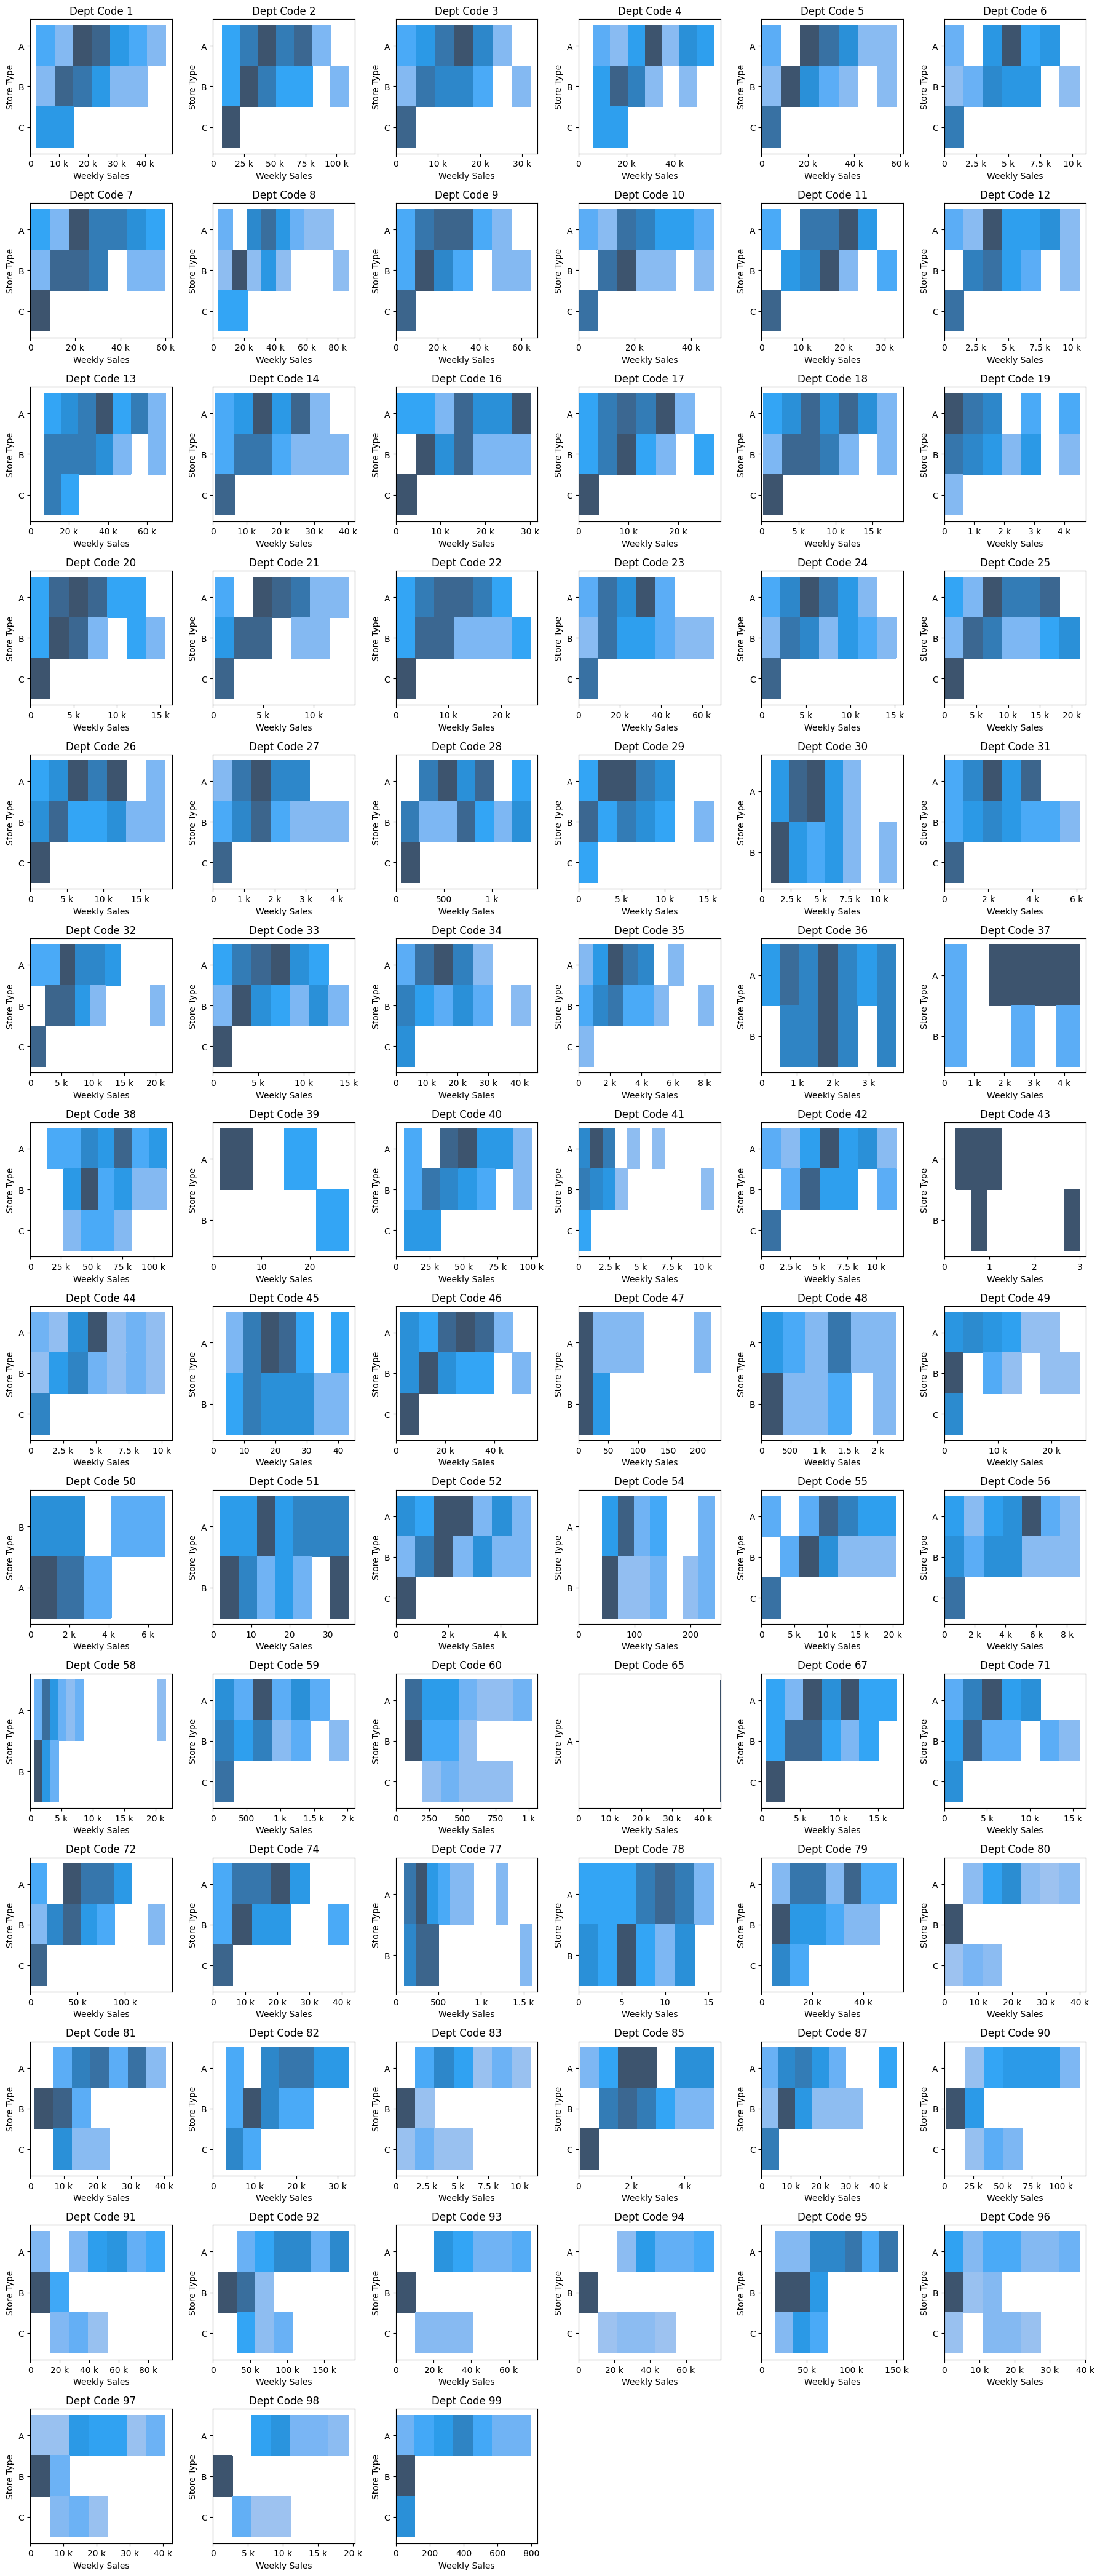

In [8]:
# Get unique values in Dept
unique_groups = Sales_df['Dept'].drop_duplicates().sort_values()

# Number of plots per row
plots_per_row = 6

# Calculate the required number of rows
num_rows = math.ceil(len(unique_groups) / plots_per_row)

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=plots_per_row, figsize=(18, 3 * num_rows))
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Loop through each unique value in Dept and corresponding axes
for idx, group in enumerate(unique_groups):
    # Filter data for the current group
    group_data = Sales_df[Sales_df['Dept'] == group].groupby(['Store', 'Type'])['Weekly_Sales'].mean().reset_index()

    # Create a scatterplot for the current group
    sns.histplot(
        data=group_data,
        x='Weekly_Sales',
        y='Type',
        ax=axes[idx],  # Pass the specific subplot axis
        palette='viridis'
    )

    # Add labels and title
    axes[idx].set_title(f'Dept Code {group}')
    axes[idx].set_xlabel('Weekly Sales')
    axes[idx].set_ylabel('Store Type')
    axes[idx].set_xlim(0,)
    axes[idx].xaxis.set_major_formatter(EngFormatter())  # Format x-axis for better readability

# Hide any unused axes
for ax in axes[len(unique_groups):]:
    ax.set_visible(False)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


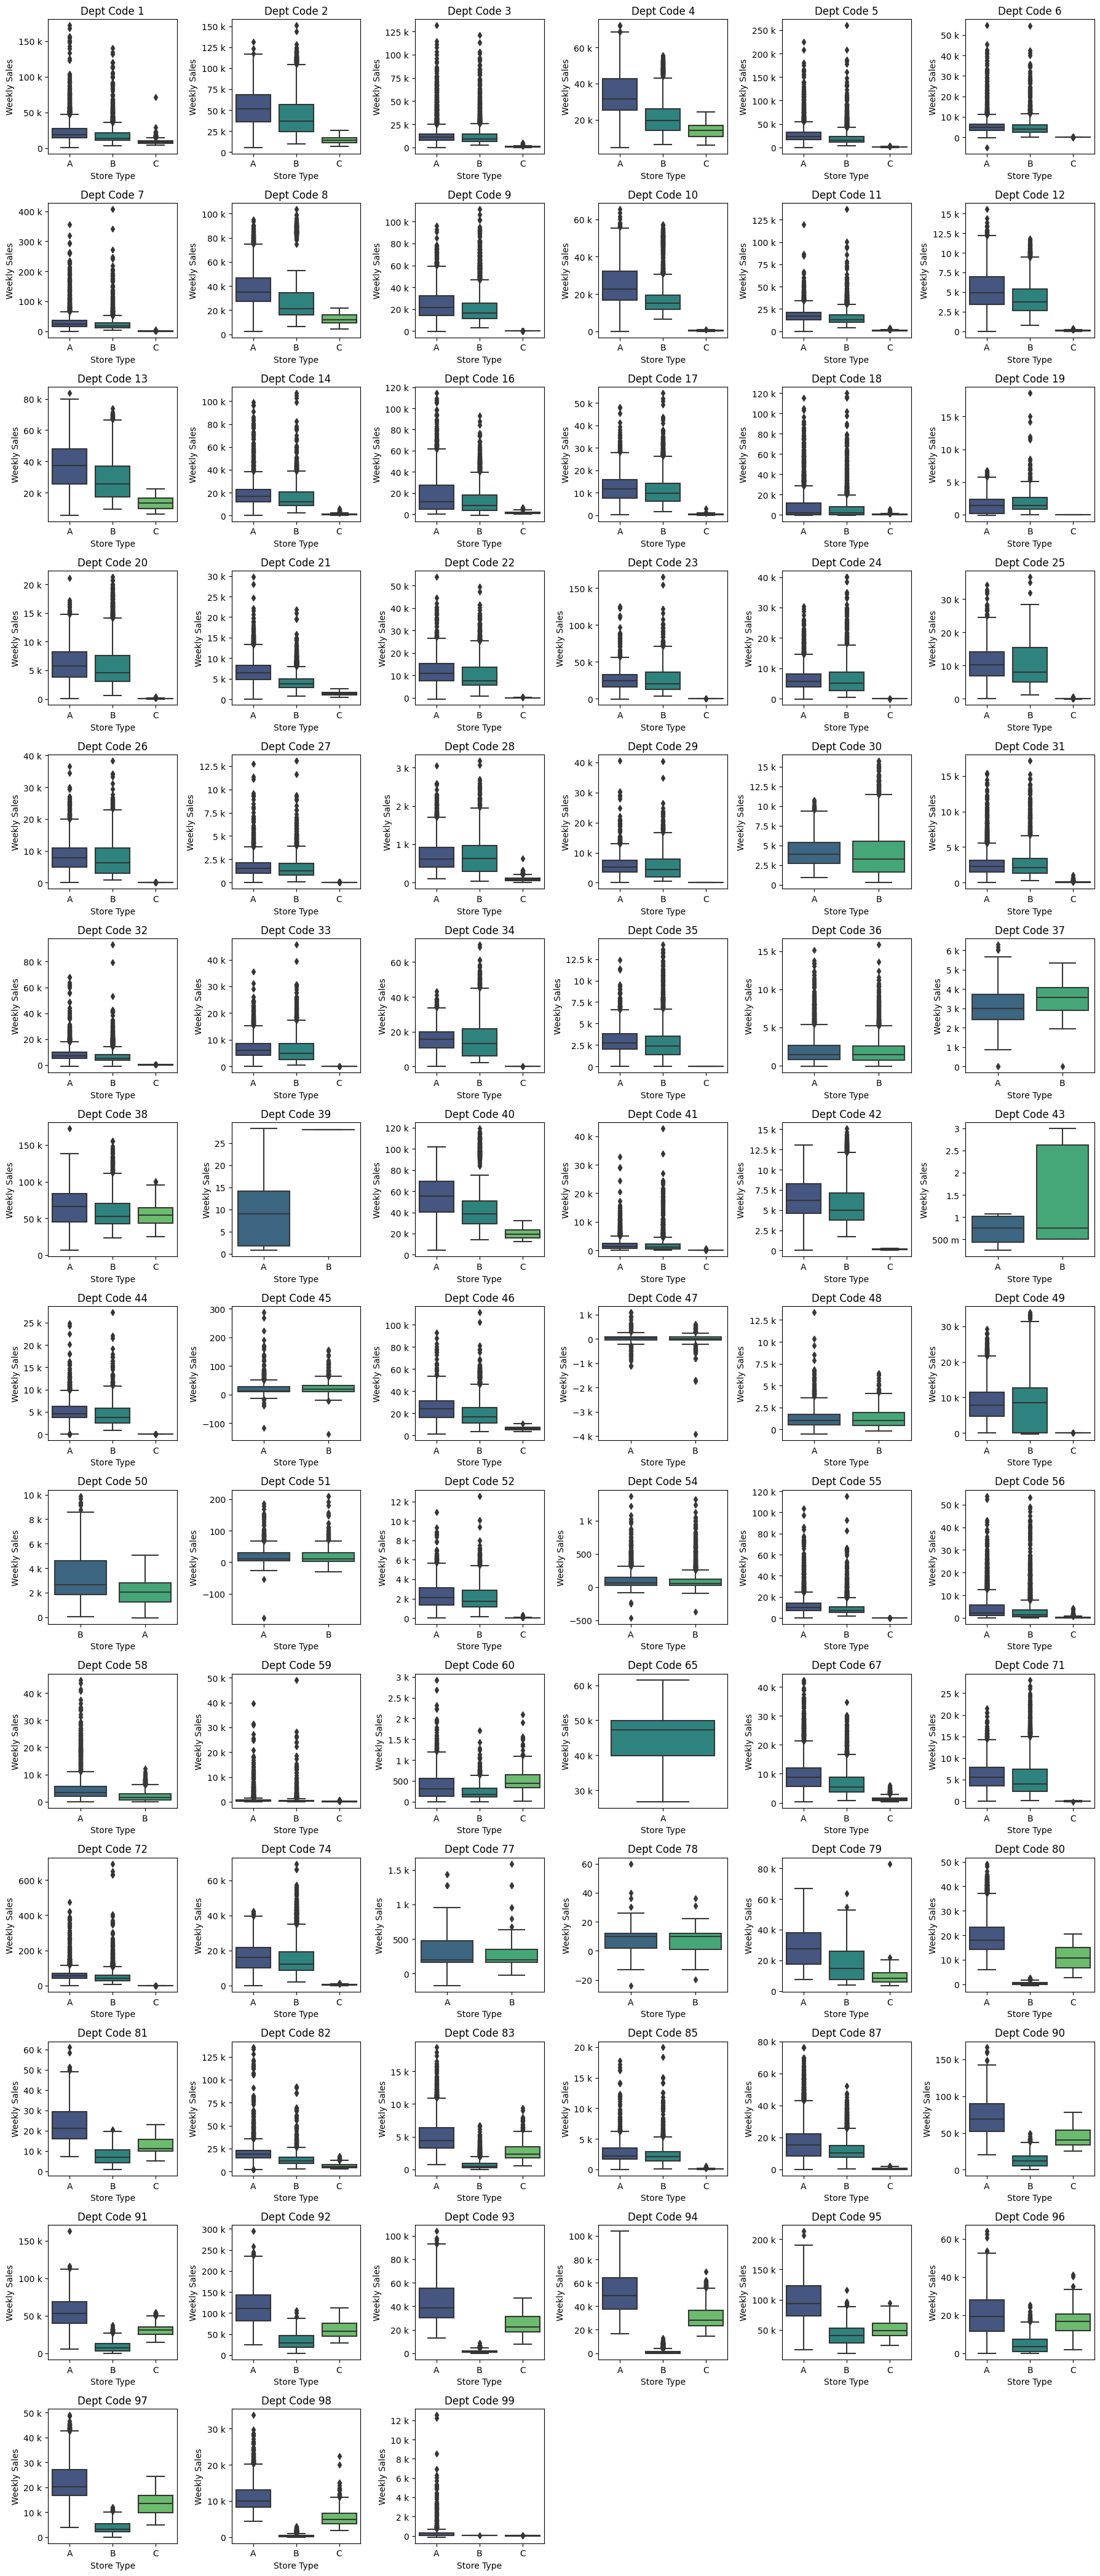

In [9]:
# Get unique values in Dept
unique_groups = Sales_df['Dept'].drop_duplicates().sort_values()
# Number of plots per row
plots_per_row = 6

# Calculate the required number of rows
num_rows = math.ceil(len(unique_groups) / plots_per_row)

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=plots_per_row, figsize=(18, 3 * num_rows))
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Loop through each unique value in Dept and corresponding axes
for idx, group in enumerate(unique_groups):
    # Filter data for the current group
    group_data = Sales_df.loc[Sales_df['Dept'] == group, ['Weekly_Sales', 'Type']].dropna()
    
    # Create a boxplot for the current group
    sns.boxplot(
        data=group_data,
        x='Type',
        y='Weekly_Sales',
        ax=axes[idx],
        palette='viridis'
    )
    
    # Add labels and title
    axes[idx].set_title(f'Dept Code {group}')
    axes[idx].set_ylabel('Weekly Sales')
    axes[idx].set_xlabel('Store Type')
    axes[idx].yaxis.set_major_formatter(ticker.EngFormatter())
    

# Hide any unused axes
for ax in axes[len(unique_groups):]:
    ax.set_visible(False)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


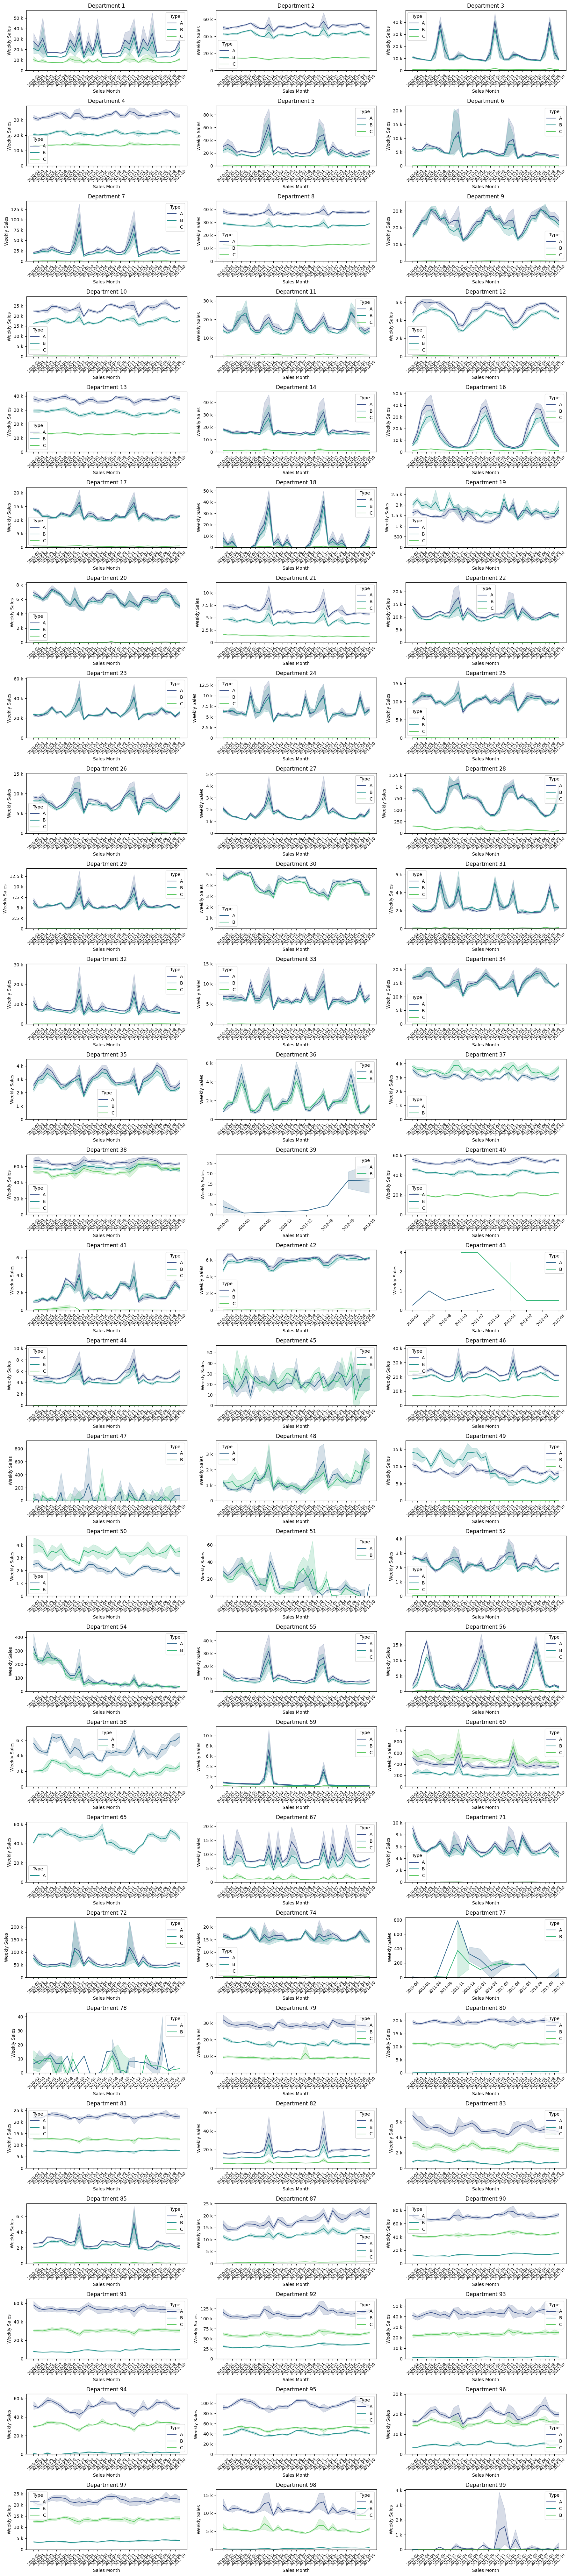

In [10]:
# Summarize data by month, department, and type
Sales_df_plot = (
    Sales_df.groupby(['Date', 'Dept', 'Type'])['Weekly_Sales']
    .mean()
    .reset_index()
    .sort_values(by=['Dept', 'Date'])
)

# Get unique department values
unique_groups = Sales_df_plot['Dept'].drop_duplicates().sort_values()

# Number of plots per row
plots_per_row = 3

# Calculate the required number of rows
num_rows = math.ceil(len(unique_groups) / plots_per_row)

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=plots_per_row, figsize=(18, 3 * num_rows))
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Loop through each department and create a subplot
for idx, group in enumerate(unique_groups):
    # Filter data for the current department
    group_data = Sales_df_plot[Sales_df_plot['Dept'] == group].copy()
    group_data['SalesYearMonth'] = group_data['Date'].dt.to_period('M').astype(str)  # Convert to "YYYY-MM" format
    
    # Lineplot for the current department
    sns.lineplot(
        data=group_data,
        x='SalesYearMonth',
        y='Weekly_Sales',
        hue='Type',
        ax=axes[idx],
        palette='viridis'
    )
    
    # Format labels and titles
    axes[idx].set_title(f'Department {group}')
    axes[idx].set_ylabel('Weekly Sales')
    axes[idx].set_xlabel('Sales Month')
    axes[idx].tick_params(axis='x', rotation=45, labelsize='small')  # Rotate x-axis labels
    axes[idx].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[idx].set_ylim(0,)


# Hide unused subplots
for ax in axes[len(unique_groups):]:
    ax.set_visible(False)

# Adjust layout and display the plot

plt.tight_layout()
plt.show()


## Department Grouping

It is evident that the 99 different departments can potentially be regrouped to enable better benchmarking  

- from the analysis so far these are the current identified groupings  
    Departments only present in type A and B stores - further grouped by Department avg weekly sales eg. 50, 51, 54, 58, 49, 48, 47, 45, 37, 36  
    Departments present in all 3 but sales in B are significantly less than those of A or C = eg. Dept 98, 97, 96, 94, 93, 92 ,91 , 90 and possibly 95, 80, 81, 83  
    Departments with little or no visible seasonal variation dept 97,  
    Departments only operating in 1 store  
    Departments with Negative , sub 1000 sales per week or which does not 
    trade every month. eg. 77, 78, 99, 51, 54, 60, 43, 39  
    Departments only present in type A eg. 65  
    Departments Summer Seasonality eg. 97, 95, 94  
    Departments Winter Seasonality eg. 82, 85, 72, 60, 59, 44, 46, 23 ,27 29  
    Departments Easter Seasonality eg. 56, 55, 36  

Proposed Business Rules for Definitions.  

In [ ]:
## Create module to classify Departments - requires that Stores_retail-data.csv and Sales_retail-data.csv have been imported and merged.

    # create a datafile listing Departments, counting the number of stores per type, no of unique trading periods per type, average annual weekly sales by type, average winter,spring,summer,autumn sales by type, average holiday sales by type, average non holiday sales by type
    Departments = Sales_df.groupby('Dept','Type').agg{'Weekly_Sales': 'mean', "Store": pd.Series.nunique, "Date": pd.Series.nunique, }
    Departments = Departments.rename(columns={
            'Weekly_Sales_mean': 'Average Sales',
            'Store_nunique': 'Unique Stores',
            'Date_nunique': 'Unique Dates'
            })

In [15]:
## Use One Hot Encoding on Type, 
DeptClassification_Pipeline = Pipeline([
        ( 'drop_na', DropMissingData()),
        ('ohe', OneHotEncoder(variables=['Type', 'SalesSeason', 'SpecialDate'], drop_last=True) )
])

DeptStep1 = DeptClassification_Pipeline.fit_transform(Sales_df)
DeptStep1


Store Dept       Date  Weekly_Sales  IsHoliday    Size  SalesYear  \
0          1    1 2010-02-05      24924.50      False  151315       2010   
1          1    1 2010-02-12      46039.49       True  151315       2010   
2          1    1 2010-02-19      41595.55      False  151315       2010   
3          1    1 2010-02-26      19403.54      False  151315       2010   
4          1    1 2010-03-05      21827.90      False  151315       2010   
...      ...  ...        ...           ...        ...     ...        ...   
421565    45   98 2012-09-28        508.37      False  118221       2012   
421566    45   98 2012-10-05        628.10      False  118221       2012   
421567    45   98 2012-10-12       1061.02      False  118221       2012   
421568    45   98 2012-10-19        760.01      False  118221       2012   
421569    45   98 2012-10-26       1076.80      False  118221       2012   

        SalesMonth  SalesQuarter  SalesWeek  ...  SalesSeason_Winter  \
0                2             1          5  ...                   1   
1                2             1          6  ...                   1   
2                2             1          7  ...                   1   
3                2             1          8  ...                   1   
4                3             1          9  ...                   0   
...            ...           ...        ...  ...                 ...   
421565           9             3         39  ...                   0   
421566          10             4         40  ...                   0   
421567          10             4         41  ...                   0   
421568          10             4         42  ...                   0   
421569          10             4         43  ...                   0   

        SalesSeason_Spring  SalesSeason_Summer  SpecialDate_Winter  \
0                        0                   0                   1   
1                        0                   0                   1   
2                        0                   0                   1   
3                        0                   0                   1   
4                        1                   0                   0   
...                    ...                 ...                 ...   
421565                   0                   0                   0   
421566                   0                   0                   0   
421567                   0                   0                   0   
421568                   0                   0                   0   
421569                   0                   0                   0   

        SpecialDate_Easter  SpecialDate_Spring  SpecialDate_Summer  \
0                        0                   0                   0   
1                        0                   0                   0   
2                        0                   0                   0   
3                        0                   0                   0   
4                        1                   0                   0   
...                    ...                 ...                 ...   
421565                   0                   0                   0   
421566                   0                   0                   0   
421567                   0                   0                   0   
421568                   0                   0                   0   
421569                   0                   0                   0   

        SpecialDate_Schoolholidays  SpecialDate_Autumn  SpecialDate_Halloween  
0                                0                   0                      0  
1                                0                   0                      0  
2                                0                   0                      0  
3                                0                   0                      0  
4                                0                   0                      0  
...                            ...                 ...             

In [14]:
Departments.query('Average_Sales <=5000')

Average_Sales  Unique_Stores  Unique_Dates  Unique_Type
Dept                                                         
6       4747.856188             45           143            3
12      4175.397021             45           143            3
19      1654.815030             38           143            3
21      4982.850828             45           143            3
27      1583.437727             44           143            3
28       618.085116             43           143            3
30      4118.197208             37           143            2
31      2339.440287             45           143            3
35      2921.044946             39           143            3
36      2022.571061             39           143            2
37      3111.076193             20           143            2
39        11.123750              5            16            2
41      1965.559998             42           143            3
43         1.193333              5            12            2
44      4651.729658             45           143            3
45        23.211586             37           143            2
47        -7.682554             37           138            2
48      1344.893576             25           143            2
50      2658.897010             14           143            2
51        21.931729             37           131            2
52      1928.356252             45           143            3
54       108.305985             37           143            2
56      3833.706211             45           143            3
58      3702.907419             34           143            2
59       694.463564             45           143            3
60       347.370229             45           143            3
77       328.961800             37            35            2
78         7.296638             37            82            2
83      3383.349838             43           143            3
85      2264.359407             44           143            3
99       415.487065             37            94            3

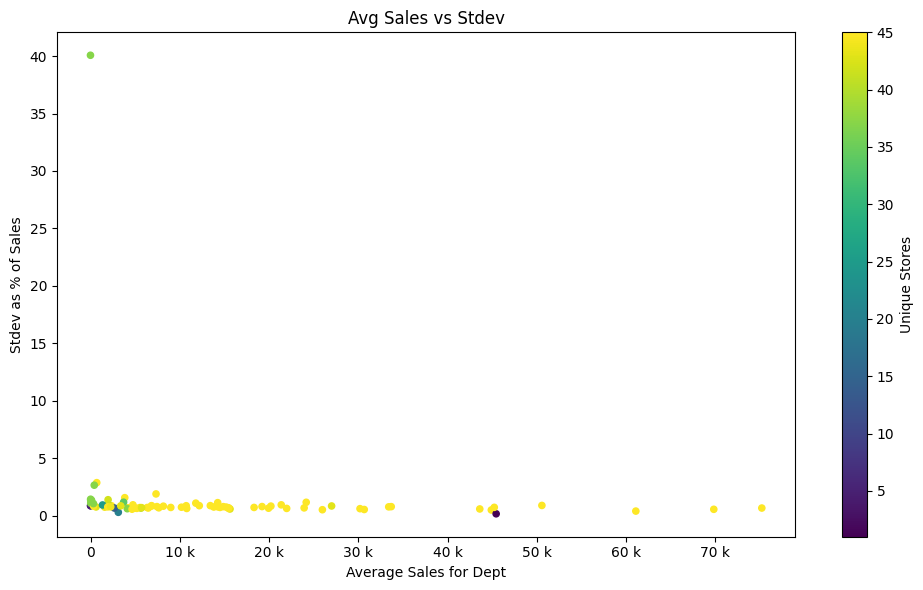

In [28]:
# Group and summarize data
Departments_summary = Sales_df.groupby('Dept').agg({
    "Weekly_Sales": ['sum', 'mean', 'min', 'max', 'std', 'var'],
    "Store": pd.Series.nunique
}).reset_index()

# Flatten the MultiIndex columns
Departments_summary.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in Departments_summary.columns]

# Rename columns for clarity
Departments_summary = Departments_summary.rename(columns={
    'Weekly_Sales_sum': 'Total Sales',
    'Weekly_Sales_mean': 'Average Sales',
    'Weekly_Sales_min': 'Minimum Sales',
    'Weekly_Sales_max': 'Maximum Sales',
    'Weekly_Sales_std': 'Sales Std Dev',
    'Weekly_Sales_var': 'Sales Variance',
    'Store_nunique': 'Unique Stores'
})

Departments_summary['PercStdev'] = np.sqrt(np.square(Departments_summary['Sales Std Dev'])/np.square(Departments_summary['Average Sales']))

# Create the scatter plot
fig, ax = plt.subplots(figsize=(10, 6))

scatter = Departments_summary.plot(
    kind='scatter',
    x='Average Sales',
    y='PercStdev',
    c='Unique Stores',
    colormap='viridis',
    ax=ax
)

# Add titles and labels
ax.set_title('Avg Sales vs Stdev')
ax.set_ylabel('Stdev as % of Sales')
ax.set_xlabel('Average Sales for Dept')

# Format axes
ax.xaxis.set_major_formatter(ticker.EngFormatter())
ax.yaxis.set_major_formatter(ticker.EngFormatter())

# Show plot
plt.tight_layout()
plt.show()


In [33]:
    # create a datafile listing Departments, counting the number of stores per type, no of unique trading periods per type, average annual weekly sales by type, average winter,spring,summer,autumn sales by type, average holiday sales by type, average non holiday sales by type
    Departments2 = Sales_df.groupby(['Dept','Type']).agg({'Weekly_Sales': 'mean', "Store": pd.Series.nunique, "Date": pd.Series.nunique })
    Departments2 = Departments2.rename(columns={
            'Weekly_Sales_mean': 'Average Sales',
            'Store_nunique': 'Unique Stores',
            'Date_nunique': 'Unique Dates'
            })

In [37]:
Departments2.unpack(0)

AttributeError: 'DataFrame' object has no attribute 'unpack'

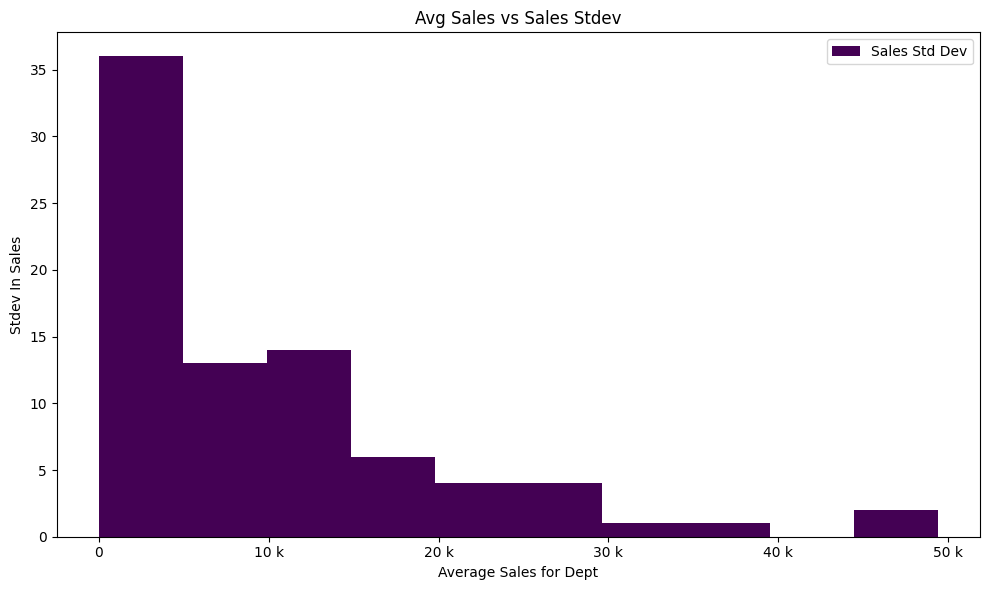

In [36]:
# Create the histogram plot
fig, ax = plt.subplots(figsize=(10, 6))

scatter = Departments_summary.plot(
    kind='hist',
    x='Average Sales',
    y='Sales Std Dev',
    # c='Unique Stores',
    colormap='viridis',
    ax=ax
)

# Add titles and labels
ax.set_title('Avg Sales vs Sales Stdev')
ax.set_ylabel('Stdev In Sales')
ax.set_xlabel('Average Sales for Dept')

# Format axes
ax.xaxis.set_major_formatter(ticker.EngFormatter())
ax.yaxis.set_major_formatter(ticker.EngFormatter())

# Show plot
plt.tight_layout()
plt.show()



---